In [3]:
# --- user config ---
PROJECT_DIR = "/project/aip-medilab/ewillis/pca_contrastive/mri_model_medsam_finetune_2D"  # <-- change me: folder with dataset_picai_slices.py and ISUPMedSAM.py

# --- imports ---
%matplotlib inline
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import numpy as np

# make local modules importable
proj_path = Path(PROJECT_DIR).expanduser().resolve()
if str(proj_path) not in sys.path:
    sys.path.insert(0, str(proj_path))

from dataset_picai_slices import PicaiSliceDataset

# try to import the model's actual resize + IMG_SIZE
try:
    from ISUPMedSAM import IMG_SIZE, resize_to_img_size as _model_resize
    _HAS_MODEL_RESIZE = True
except Exception as e:
    print(f"[warn] Could not import from ISUPMedSAM; falling back to bilinear resize. Error: {e}")
    _HAS_MODEL_RESIZE = False
    IMG_SIZE = 1024
    import torch.nn.functional as F
    def _model_resize(x: torch.Tensor) -> torch.Tensor:
        return F.interpolate(x, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)


In [4]:
def _show_channels(img_chw: torch.Tensor, title_prefix: str = "") -> None:
    """
    Display up to 3 channels from a [C,H,W] tensor scaled in [0,1].
    """
    C, H, W = img_chw.shape
    n = min(3, C)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]
    for i in range(n):
        ax = axes[i]
        ax.imshow(img_chw[i].cpu().numpy(), cmap="gray", vmin=0.0, vmax=1.0)
        ax.set_title(f"ch{i}")
        ax.axis("off")
    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()


In [5]:
def preview_picai_slice(
    manifest: str,
    *,
    index: int = 0,
    case_id: str | None = None,
    z: int | None = None,
    folds: str | None = None,      # e.g., "0,1,2"
    target: str = "isup3",
    channels: str = "path_T2,path_ADC,path_HBV",
    missing_channel_mode: str = "zeros",
    pct_lower: float = 0.5,
    pct_upper: float = 99.5,
    model_view: bool = True,       # if True, applies model's exact resize
) -> dict:
    """
    Load one sample from the manifest and display channels inline.
    Returns a dict with the tensors and metadata for further debugging.
    """
    # prepare args
    folds_list = None
    if folds and folds.strip():
        folds_list = [s.strip() for s in folds.split(",") if s.strip()]
    channel_tuple = tuple(s.strip() for s in channels.split(",") if s.strip())

    # dataset (no transform: see raw dataset behavior)
    ds = PicaiSliceDataset(
        manifest_csv=manifest,
        folds=folds_list,
        use_skip=True,
        target=target,
        channels=channel_tuple,
        missing_channel_mode=missing_channel_mode,
        pct_lower=pct_lower,
        pct_upper=pct_upper,
        transform=None,
        cache_size=64,
    )

    # select row by (case_id, z) or numeric index
    if case_id is not None:
        sub = ds.df[ds.df["case_id"].astype(str) == str(case_id)]
        if z is not None:
            sub = sub[sub["z"].astype(int) == int(z)]
        if len(sub) == 0:
            raise ValueError(f"No rows matched case_id={case_id!r}" + (f" and z={z}" if z is not None else ""))
        idx = int(sub.index[0])
    else:
        idx = int(index)
        if idx < 0 or idx >= len(ds):
            raise IndexError(f"index {idx} out of range [0, {len(ds)-1}]")

    sample = ds[idx]
    img: torch.Tensor = sample["image"]  # [C,H,W], cropped + windowed to [0,1]
    has_lesion = int(sample["has_lesion"])
    label6 = int(sample["label6"])
    label = int(sample["label"])
    cid = str(sample["case_id"])
    z_idx = int(sample["z"])
    bbox = tuple(sample["bbox"])
    ch_paths = sample["channels"]

    img_to_show = img
    if model_view:
        img_to_show = _model_resize(img.unsqueeze(0)).squeeze(0)  # [C,IMG_SIZE,IMG_SIZE]

    # summary
    print("\n[summary]")
    print(f"  case_id: {cid}")
    print(f"  fold:    {sample['fold']}")
    print(f"  z:       {z_idx}")
    print(f"  bbox:    (z0={bbox[0]}, z1={bbox[1]}, h0={bbox[2]}, h1={bbox[3]}, w0={bbox[4]}, w1={bbox[5]})")
    print(f"  target:  {target} | label={label} | label6={label6} | has_lesion={has_lesion}")
    print("  channels:")
    for k, v in ch_paths.items():
        print(f"    - {k}: {v if v else '(missing)'}")
    print(f"  original shape: {tuple(img.shape)}"
          + (f" -> resized: {tuple(img_to_show.shape)}" if model_view else "")
          + " (C,H,W)")
    if model_view:
        print(f"  IMG_SIZE: {IMG_SIZE} | resize func: {'imported' if _HAS_MODEL_RESIZE else 'fallback bilinear'}")

    title = f"{cid}  z={z_idx}  lesion={has_lesion}  label={label} (label6={label6})" + (f"  size={IMG_SIZE}" if model_view else "")
    _show_channels(img_to_show, title_prefix=title)

    return {
        "image_dataset": img,              # [C,H,W]
        "image_model_view": img_to_show,   # [C,S,S] if model_view else same as dataset
        "meta": {
            "case_id": cid,
            "z": z_idx,
            "bbox": bbox,
            "fold": sample["fold"],
            "label": label,
            "label6": label6,
            "has_lesion": has_lesion,
            "channels": ch_paths,
        },
    }


In [6]:
# === NEW CELL: load lesion mask, match crop+resize, and overlay on channels ===
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

try:
    import nibabel as nib
except Exception:
    nib = None

import torch.nn.functional as F

def _load_mask_slice(mask_path: str, z_idx: int) -> np.ndarray:
    """
    Load a 2D lesion mask for the given z-index.
    Supports:
      - NIfTI (.nii/.nii.gz): reads 3D and extracts slice along last axis (H,W,Z)->[..., z]
      - NumPy (.npy): 2D or 3D; if 3D, assumes last axis is Z
      - Image files (.png/.jpg/.jpeg): assumes a single 2D mask already for this slice
    Returns a uint8 array in {0,1}.
    """
    p = Path(mask_path)
    ext = p.suffix.lower()
    if ext == ".gz" and p.name.endswith(".nii.gz"):
        ext = ".nii.gz"

    if ext in (".nii", ".nii.gz"):
        if nib is None:
            raise ImportError("nibabel is required to read NIfTI masks")
        vol = nib.load(str(p)).get_fdata()
        vol = np.asarray(vol)
        # Heuristic: assume shape (H, W, Z)
        if vol.ndim != 3:
            raise ValueError(f"Expected 3D NIfTI mask, got shape {vol.shape}")
        if not (0 <= z_idx < vol.shape[-1]):
            raise IndexError(f"z index {z_idx} out of range for mask with Z={vol.shape[-1]}")
        sl = vol[..., z_idx]
    elif ext == ".npy":
        arr = np.load(str(p))
        if arr.ndim == 2:
            sl = arr
        elif arr.ndim == 3:
            if not (0 <= z_idx < arr.shape[-1]):
                raise IndexError(f"z index {z_idx} out of range for 3D npy mask with Z={arr.shape[-1]}")
            sl = arr[..., z_idx]
        else:
            raise ValueError(f"Unsupported npy mask shape: {arr.shape}")
    elif ext in (".png", ".jpg", ".jpeg"):
        # 2D mask image
        from PIL import Image
        sl = np.array(Image.open(str(p)).convert("L"))
    else:
        raise ValueError(f"Unsupported mask extension: {ext}")

    # Binarize
    sl = (sl > 0).astype(np.uint8)
    return sl


def _resize_mask_to_model(mask_hw: np.ndarray, size: int) -> np.ndarray:
    """
    Nearest-neighbor resize to (size, size). Returns uint8 {0,1}.
    """
    t = torch.from_numpy(mask_hw.astype(np.float32))[None, None, ...]  # [1,1,H,W]
    t = F.interpolate(t, size=(size, size), mode="nearest")
    out = t[0, 0].round().byte().cpu().numpy()
    return out


def overlay_mask_on_channels(result_dict: dict, mask_path: str, alpha: float = 0.35) -> None:
    """
    Given the dict returned by preview_picai_slice(...), load the lesion mask from mask_path,
    apply SAME crop (h0:h1, w0:w1) and SAME resize (IMG_SIZE) as the image shown,
    then overlay on all displayed channels.
    """
    meta = result_dict["meta"]
    img = result_dict["image_model_view"] if "image_model_view" in result_dict else result_dict["image_dataset"]
    # Detect if model_view was used by shape vs IMG_SIZE
    model_view_used = img.shape[-1] == IMG_SIZE and img.shape[-2] == IMG_SIZE

    # Load full-slice mask (before crop/resize)
    z_idx = int(meta["z"])
    full_mask = _load_mask_slice(mask_path, z_idx=z_idx)  # [Hfull, Wfull] in {0,1}

    # Apply SAME crop used by dataset
    # bbox: (z0, z1, h0, h1, w0, w1)
    _, _, h0, h1, w0, w1 = meta["bbox"]
    cropped_mask = full_mask[h0:h1, w0:w1]  # [Hc, Wc]

    # If model_view was used, resize mask to IMG_SIZE with NEAREST
    if model_view_used:
        mask_to_show = _resize_mask_to_model(cropped_mask, IMG_SIZE)
    else:
        mask_to_show = cropped_mask

    # Prepare figure
    C, H, W = img.shape
    n = min(3, C)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]

    title = f"{meta['case_id']}  z={meta['z']}  lesion={meta['has_lesion']}  label={meta['label']} (label6={meta['label6']})"
    if model_view_used:
        title += f"  size={IMG_SIZE}"

    # Plot each channel with overlay
    for i in range(n):
        ax = axes[i]
        ax.imshow(img[i].cpu().numpy(), cmap="gray", vmin=0.0, vmax=1.0)
        ax.imshow(mask_to_show, cmap="Reds", alpha=alpha, interpolation="nearest")
        ax.set_title(f"ch{i} + mask")
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()





[summary]
  case_id: 10013_1000013
  fold:    4
  z:       0
  bbox:    (z0=0, z1=24, h0=127, h1=259, w0=122, w1=225)
  target:  isup3 | label=0 | label6=0 | has_lesion=0
  channels:
    - path_T2: /project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10013_1000013_0000.nii.gz
    - path_ADC: /project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10013_1000013_0001.nii.gz
    - path_HBV: /project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10013_1000013_0002.nii.gz
  original shape: (3, 132, 103) -> resized: (3, 256, 256) (C,H,W)
  IMG_SIZE: 256 | resize func: imported


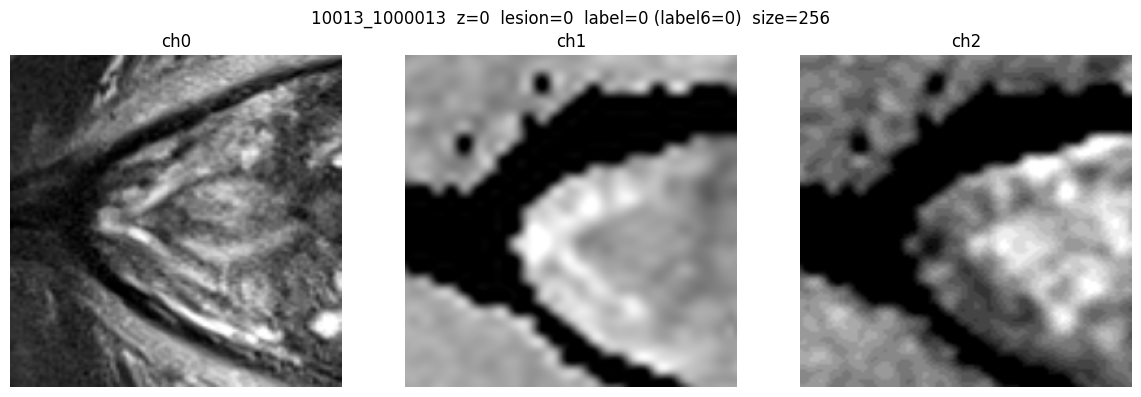

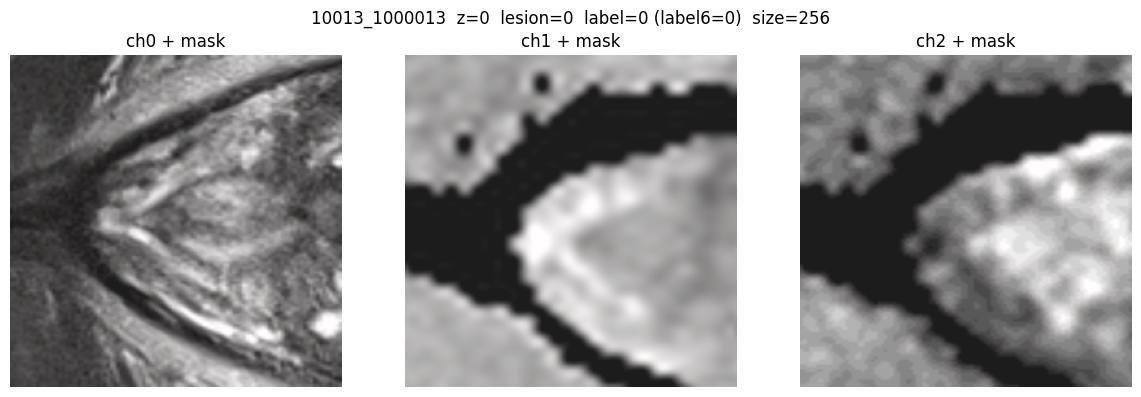

In [7]:
result = preview_picai_slice(
    manifest="/project/aip-medilab/shared/picai/manifests/slices_manifest_filtered.csv",
    # folds="0",                  # or None for all folds
    # index=6,                    # or use case_id="ProstateX-0001", z=12
    case_id="10013_1000013",
    z=0,
    target="isup3",
    channels="path_T2,path_ADC,path_HBV",
    missing_channel_mode="zeros",
    pct_lower=0.5, pct_upper=99.5,
    model_view=True,            # show exactly what the model sees
)

mask_path = "/project/aip-medilab/shared/picai/picai_prepped_registered/labelsTr_lesion/10013_1000013.nii.gz"  # <-- change me

overlay_mask_on_channels(result, mask_path, alpha=0.12)


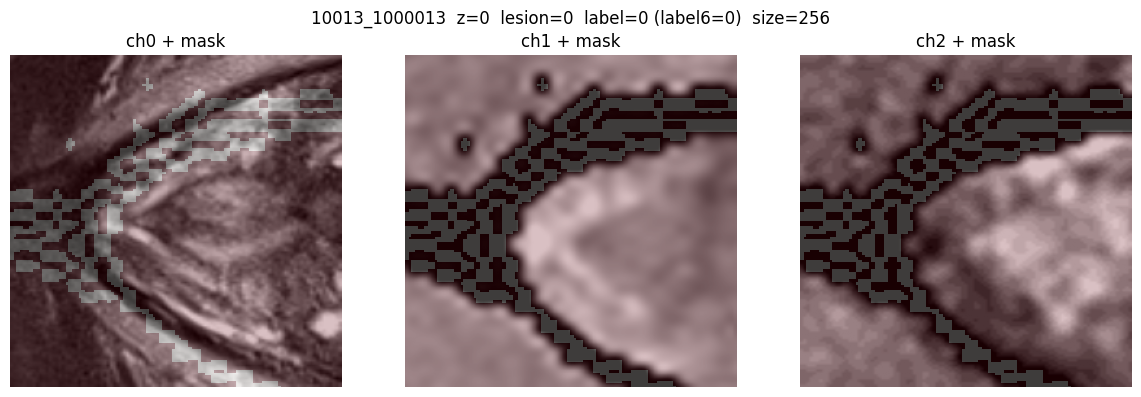

In [8]:
mask_path = "/project/aip-medilab/shared/picai/picai_prepped_registered/imagesTr/10013_1000013_0001.nii.gz"  # <-- change me

overlay_mask_on_channels(result, mask_path, alpha=0.25)
